# quadratic estimator tests

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from matplotlib import gridspec
import numpy as np
import os
import copy
import hera_pspec as hp
from pyuvdata import UVData, UVBeam
from memory_profiler import memory_usage
import glob
from scipy import signal, stats, special, interpolate
from scipy.stats import multivariate_normal as mn
from sklearn import gaussian_process as gp
import hera_sim as hs
import uvtools as uvt
import hera_cal as hc
import pspec_qe as qe
from hera_cal.datacontainer import DataContainer as DC
import palettable as pt

In [3]:
mpl.rc('font', serif='Times New Roman', family='serif')
mpl.rc('text', usetex=True)
#mpl.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}'

## setup covariances

In [4]:
Kfg = gp.kernels.ConstantKernel(1e2) * gp.kernels.RBF(length_scale=5.0)

Keor1 = gp.kernels.ConstantKernel(1e-6) * gp.kernels.Matern(length_scale=0.1, nu=0.5)
Keor2 = gp.kernels.ConstantKernel(1e-6) * gp.kernels.Matern(length_scale=0.2, nu=0.5)
Keor3 = gp.kernels.ConstantKernel(1e-6) * gp.kernels.Matern(length_scale=0.5, nu=0.5)
Keor4 = gp.kernels.ConstantKernel(1e-6) * gp.kernels.Matern(length_scale=0.75, nu=0.5)

Knoise = gp.kernels.WhiteKernel(noise_level=1e-6)

In [5]:
cosmo = hp.conversions.Cosmo_Conversions()
t2k = cosmo.tau_to_kpara(8.5)

## generate data

In [6]:
freqs = np.linspace(120, 140, 64)
Nfreqs = len(freqs)

In [7]:
Kf = Kfg(freqs[:, None])
Ke1 = Keor1(freqs[:, None])
Ke2 = Keor2(freqs[:, None])
Ke3 = Keor3(freqs[:, None])
Ke4 = Keor4(freqs[:, None])
Kn = Knoise(freqs[:, None])

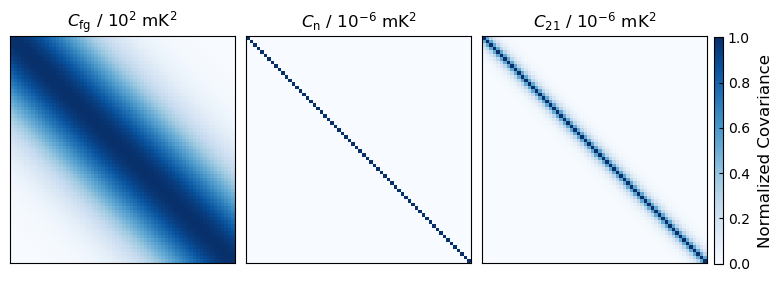

In [2876]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=100)
fig.subplots_adjust(wspace=0.05)
cmap = 'Blues'

ax = axes[0]
ax.tick_params(direction='in', size=0, color='w')
cax = ax.imshow(Kf / Kf.max(), cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_title(r"$C_{{\rm fg}}\ /\ 10^{{{:.0f}}}\ {{\rm mK^2}}$".format(np.log10(Kf.max())), fontsize=12)

ax = axes[1]
ax.tick_params(direction='in', size=0, color='w')
cax = ax.imshow(Kn / Kn.max(), cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_title(r"$C_{{\rm n}}\ /\ 10^{{{:.0f}}}\ {{\rm mK^2}}$".format(np.log10(Ke3.max())), fontsize=12)

ax = axes[2]
ax.tick_params(direction='in', size=0, color='w')
cax = ax.imshow(Ke3 / Ke3.max(), cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_title(r"$C_{{\rm 21}}\ /\ 10^{{{:.0f}}}\ {{\rm mK^2}}$".format(np.log10(Kn.max())), fontsize=12)

cbax = fig.add_axes([0.85, 0.1, 0.067, 0.8])
cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, aspect=25)
cbar.ax.tick_params(direction='in', size=3)
cbar.set_label("Normalized Covariance", fontsize=12, labelpad=6)


In [8]:
np.random.seed(0)
k = (1, 2, 'xx')
mean = np.zeros_like(freqs)
F = DC({k : mn.rvs(mean, Kf/2, 1000) + 1j * mn.rvs(mean, Kf/2, 1000)})
E = DC({k : mn.rvs(mean, Ke4/2, 1000) + 1j * mn.rvs(mean, Ke4/2, 1000)})
N = DC({k : mn.rvs(mean, Kn/2, 1000) + 1j * mn.rvs(mean, Kn/2, 1000)})

In [49]:
nfac = 2e0
efac = 1e0

In [50]:
T = F + E * efac + N * nfac

In [1976]:
#Kn = np.eye(64) * np.logspace(-6, -5.3, 64) * nfac**2

In [51]:
Kn = Knoise(freqs[:, None]) * nfac**2

In [52]:
Ke = Ke4 * efac**2

In [53]:
iC = np.linalg.inv(Kf + Kn + Ke)
gpr = np.eye(64) - Kf @ np.linalg.inv(Kf + Kn + Ke)

In [18]:
cov_gpr = Kf - Kf @ np.linalg.pinv(Kf + Kn) @ Kf

In [19]:
dlys = np.fft.fftshift(np.fft.fftfreq(Nfreqs, np.diff(freqs)[0] / 1e3))
kp = dlys * t2k / 1e9

In [ ]:
from hera_cal.datacontainer import DataContainer as DC

class QE:
    
    def __init__(self, freqs, x1, x2=None, C=None, scalar=None, cosmo=None):
        """
        Quadratic Estimator across freqs.
        
        E = R Q R
        q = x1 E x2
        p = M q
        W = M F
        V = M F M
        nE_a = M_ab E_b
        b = tr(C, nE)
        
        Parameters
        ----------
        freqs : ndarray (Nfreqs)
            frequency array of x in Hz
        x1 : ndarray or hera_cal DataContainer (Ntimes, Nfreqs)
             Complex visibility data as left-hand input for QE
        x2 : ndarray or hera_cal DataContainer (Ntimes, Nfreqs)
             Complex visibility data as right-hand input for QE
             Default is x1
        C : ndarray (Nfreqs, Nfreqs)
            data covariance, used for errorbars
        scalar : float, optional
            Power spectrum normalization scalar to multiply into M
        cosmo : hera_pspec Cosmo_Conversions object
            Adopted cosmology. Default is hera_pspec default.
        """
        self.x1 = x1
        if x2 is None:
            self.x2 = x1
        else:
            self.x2 = x2
        self.C = C
        self.freqs = freqs
        self.Nfreqs = len(freqs)
        self.beam = beam
        # XXX TODO: multiply scalar
        self.scalar = scalar
        self.container = isinstance(x, DC)
        if cosmo is None:
            self.cosmo = hp.conversions.Cosmo_Conversions()
        else:
            self.cosmo = cosmo
        self.avg_f = np.mean(freqs)
        self.avg_z = cosmo.f2z(avg_f)
        self.t2k = cosmo.tau_to_kpara(self.avg_z)
        self.dlys = np.fft.fftfreq(Nfreqs, np.diff(freqs)[0]) * 1e9
        self.kp = self.dlys * self.t2k / 1e9
        
    def _check_type(self, A):
        if A is not None:
            if self.container:
                assert isinstance(R, DC)
            else:
                assert isinstance(R, np.ndarray)

    def set_R(self, R):
        """
        Set weighting matrix for QE.
        For proper OQE, this should be C^-1
        
        Parameters
        ----------
        R : ndarray or DataContainer (Nfreqs, Nfreqs)
        
        Results
        -------
        self.R
        """
        sefl._check_type(R)
        self.R = R
        
    def _compute_E(self, R, Q):
        if isinstance(R, DC):
            return DC({k: self._compute_E(R[k], Q) for k in R})
        return 0.5 * np.array([R.T.conj() @ Qa @ R for Qa in Q])
    
    def _compute_F(self, E, Q):
        if isinstance(E, DC):
            return DC({k: self._compute_F(E[k], Q) for k in E})
        return np.array([[np.trace(Ea @ Qb) for Qb in Q] for Ea in E])

    def compute_F(self):
        """
        Compute Fisher matrix given self.R
        
        Results
        -------
        self.F
        """
        if not hasattr(self, 'R'):
            raise ValueError("No R matrix attached to object")
        # compute Q = dC/dp
        q = np.array([np.fft.ifft(np.eye(self.Nfreqs), axis=-1)[i] for i in range(self.Nfreqs)])
        self.Q = np.fft.fftshift([_q[None, :].T.conj().dot(_q[None, :]) for _q in q], axes=0)
        
        # compute un-normalized E and then F
        self.E = self._compute_E(self.R, self.Q)
        self.F = self._compute_F(self.E, self.Q)

    def _compute_q(self, x1, x2, E):
        if isinstance(x1, DC):
            return DC({k: self._compute_q(x1[k], x2[k], E[k]) for k in x1})
        return np.einsum("ft,dfn,tn->dt", x1.T.conj(), E, x2)

    def compute_q(self):
        """
        Compute q: un-normalized band powers
        Must first compute_F
        
        Results
        -------
        self.q
        """
        if not hasattr(self, 'F'):
            raise ValueError("Must first compute_F")
        self.q = self._compute_q(self.x1, self.x2, self.E)

    def _compute_M(self, norm, F):
        if isinstance(F, DC):
            return DC({k: self._compute_M(norm, F[k]) for k in F})
        if norm == 'I':
            return np.diag(1. / np.sum(F, axis=1))
        elif norm == 'F^-1':
            return np.linalg.inv(F)
        elif norm == 'F^-1/2':
            u,s,v = np.linalg.svd(F)
            M = np.transpose(u @ (np.eye(self.Nfreqs) / np.sqrt(s)) @ v)
            W = M @ F
            # normalize
            M /= W.sum(axis=1)[:, None]
            return M

    def _compute_p(self, M, q):
        if isinstance(M, DC):
            return DC({k: self._compute_p(M[k], q[k]) for k in M})
        return M @ q
    
    def _compute_W(self, M, F):
        if isinstance(M, DC):
            return DC({k: self._compute_W(M[k], F[k]) for k in M})
        return M @ F
    
    def _compute_nE(self, M, E):
        if isinstance(M, DC):
            return DC({k: self._compute_nE(M[k], E[k]) for k in M})
        return np.array([np.sum(m[:, None, None] * E, axis=0) for m in M])

    def _compute_b(self, C, nE):
        if isinstance(C, DC):
            return DC({k: self._compute_b(C[k], nE[k]) for k in C})
        return np.array([np.trace(C @ Ea) for Ea in nE])
    
    def _compute_V(self, C, nE):
        if isinstance(C, DC):
            return DC({k: self._compute_V(C[k], nE[k]) for k in C})
        return 2 * np.array([[np.trace(C @ Ea @ C @ Eb) for Eb in nE] for Ea in nE])

    def compute_p(self, norm='I', C_data=None, C_bias=None):
        """
        Compute p: normalized bandpowers
        Must first compute_q
        Also computes window function W, normalized
        E matrix nE, bandpower covariance V, and
        bandpower bias term b.
        
        Parameters
        ----------
        norm : str, ['I', 'F^-1', 'F^-1/2']
            Bandpower normalization matrix type
        C_data : ndarray or DataContainer (Nfreqs, Nfreqs), optional
            Data covariance for errorbar estimation.
            Default is self.C
        C_bias : ndarray or DataContainer (Nfreqs, Nfreqs), optional
            Data covariance for bias term.
            Default is no bias term.
            
        Results
        -------
        self.M, self.W, self.nE, self.p, self.V, self.b
        """
        if not hasattr(self, 'q'):
            raise ValueError('Must first compute_q')
        self._check_type(C_data)
        self._check_type(C_bias)
        # get normalization matrix
        self.M = self._compute_M(norm, self.F)
        # compute window functions
        self.W = self._compute_W(self.M, self.q)
        # compute normalized bandpowers
        self.p = self._compute_p(self.M, self.q)
        # compute normalized E matrix
        self.nE = self._compute_nE(self.M, self.E)
        # compute bandpower covariance
        if C_data is None:
            C_data = self.C
        if C_data is not None:
            self.V = self._compute_V(C_data, self.nE)
        # compute bias term
        if C_bias is not None:
            self.b = self._compute_b(C_bias, self.nE)

In [113]:
less pspec_qe.py

In [22]:
def qe(x, R, C_data, C_bias, norm='I'):
    """
    x : data vector, (Ntimes, Nfreqs)
    R : weighting matrix, (Nfreqs, Nfreqs)
    C_data : data covariance for errorbars, (Nfreqs, Nfreqs)
    C_bias : data covariance for bias subtraction, (Nfreqs, Nfreqs)
    norm : ['I', 'H^-1', 'H^-1/2']
    """
    # form Q
    Nfreqs = x.shape[1]
    Q = np.array([np.fft.ifft(np.eye(Nfreqs), axis=-1)[i] for i in range(Nfreqs)])
    Q = np.fft.fftshift([q[None, :].T.conj().dot(q[None, :]) for q in Q], axes=0)
    E = 0.5 * np.array([R.T.conj() @ Qa @ R for Qa in Q])
    H = np.array([[np.trace(Ea @ Qb) for Qb in Q] for Ea in E]).real
    if norm == 'I':
        M = np.diag(1. / np.sum(H, axis=1))
    elif norm == 'H^-1':
        M = np.linalg.inv(H)
    elif norm == 'H^-1/2':
        u,s,v = np.linalg.svd(H)
        M = np.transpose(u @ (np.eye(Nfreqs) / np.sqrt(s)) @ v)
        W = M @ H
        # normalize
        M /= W.sum(axis=1)[:, None]
    W = M @ H
    nE = np.array([np.sum(m[:, None, None] * E, axis=0) for m in M])
    q = np.einsum("ft,dfn,tn->dt", x.T.conj(), E, x)
    p = M @ q
    #p = np.einsum("ft,dfn,tn->dt", x.T.conj(), nE, x)
    b = np.array([np.trace(C_bias @ Ea) for Ea in nE])
    V = 2 * np.array([[np.trace(C_data @ Ea @ C_data @ Eb) for Eb in nE] for Ea in nE])
    #V = M @ H @ M.T.conj()
    return H, nE, q, M, W, b, p, V

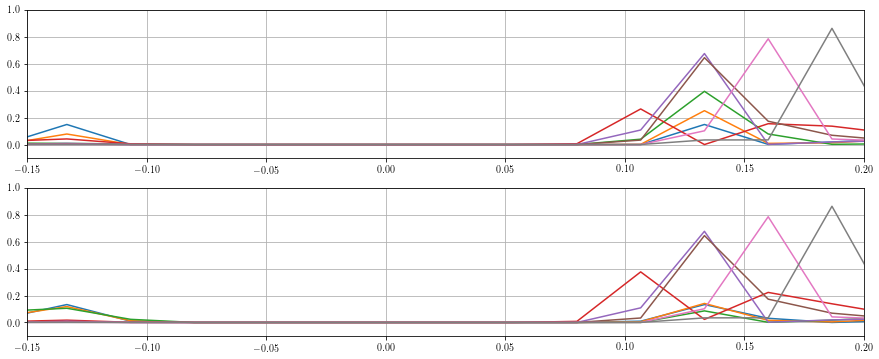

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(15,6))

ax = axes[0]
ax.plot(kp, W_q[32:40].T)
ax.set_xlim(-.15, .2)
#plt.yscale('log')
ax.set_ylim(-.1, 1)
ax.grid()

ax = axes[1]
ax.plot(kp, W_g[32:40].T)
ax.set_xlim(-.15, .2)
#plt.yscale('log')
ax.set_ylim(-.1, 1)
ax.grid()

In [24]:
t = np.eye(64) * uvt.dspec.gen_window('bh', 64)

In [93]:
H_q, E_q, q_q, M_q, W_q, b_q, p_q, V_q = qe(T[k], iC, Kf + Ke + Kn, Kf + Kn, norm='H^-1/2')
H_g, E_g, q_g, M_g, W_g, b_g, p_g, V_g = qe(T[k], gpr, Kf + Ke + Kn, Kf + Kn, norm='H^-1/2')

In [55]:
H_i, E_i, q_i, M_i, W_i, b_i, p_i, V_i = qe(T[k], t @ np.eye(64), Kf + Ke + Kn, Kn, norm='I')
H_e, E_e, q_e, M_e, W_e, b_e, p_e, V_e = qe(E[k] * efac, t @ np.eye(64), Ke, Kn, norm='I')
H_n, E_n, q_n, M_n, W_n, b_n, p_n, V_n = qe(N[k] * nfac, t @ np.eye(64), Kn, Kn, norm='I')

In [1986]:
Q = np.array([np.fft.ifft(np.eye(Nfreqs), axis=-1)[i] for i in range(Nfreqs)])
p_cov_gpr = np.fft.fftshift(np.array([q[None, :] @ t @ cov_gpr @ t @ q[None, :].T.conj() for q in Q]).squeeze())

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.4, 0.85, 'GPR')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


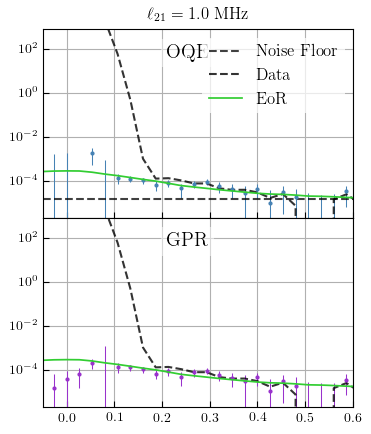

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(4, 5), dpi=100)
fig.subplots_adjust(hspace=0.0)
xlim = -.05, 0.6
ylim = 2e-6, 8e2

ax = axes[0]
ax.tick_params(labelsize=10, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
p0 = ax.axhline(np.mean(np.abs(np.mean(p_n, axis=1).real - b_n)), c='k', ls='--', lw=1.5, alpha=0.75)
p1 = ax.errorbar(kp, np.mean(p_i, axis=1).real - b_i, ls='--', c='k', lw=1.5, alpha=0.8)
p2 = ax.errorbar(kp, np.mean(p_q, axis=1).real - b_q, yerr=np.sqrt(np.diag(V_q)/1000), fmt='o', c='steelblue',
                    ms=2., elinewidth=0.75)
p3 = ax.errorbar(kp, np.mean(p_e, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.text(0.4, 0.85, 'OQE', fontsize=14, transform=ax.transAxes, bbox=dict(ec='none', fc='w', alpha=0.5))
ax.legend([p0, p1, p3], ['Noise Floor', 'Data', 'EoR'], fontsize=12, edgecolor='none', framealpha=0.75)
ax.set_title(r'$\ell_{21} = 1.0\ {\rm MHz}$', fontsize=12)

ax = axes[1]
ax.tick_params(labelsize=10, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
p0 = ax.errorbar(kp, np.mean(p_i, axis=1).real - b_i, ls='--', c='k', lw=1.5, alpha=0.8)
p1 = ax.errorbar(kp, np.mean(p_g, axis=1).real - b_g, yerr=np.sqrt(np.diag(V_g)/1000), fmt='o', c='darkorchid',
                 ms=2., elinewidth=0.75)
p2 = ax.errorbar(kp, np.mean(p_e, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.text(0.4, 0.85, 'GPR', fontsize=14, transform=ax.transAxes, bbox=dict(ec='none', fc='w', alpha=0.5))
#ax.legend([p0, p2], ['Data', 'EoR'], fontsize=12, edgecolor='none', framealpha=0.75)

Text(0, 0.5, 'Window Function')

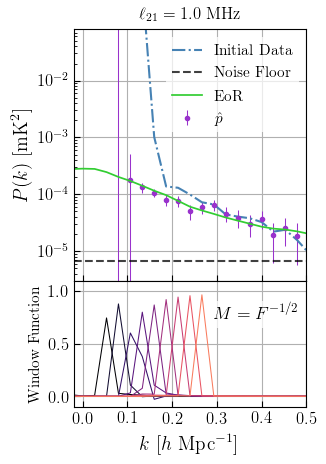

In [100]:
grid = gridspec.GridSpec(nrows=3, ncols=3)
fig = plt.figure(figsize=(3, 5), dpi=100)
fig.subplots_adjust(hspace=0)

xticks = np.arange(0, 1.0, 0.1)
xlim = -.02, 0.5
ylim = 3e-6, 8e-2

ax = fig.add_subplot(grid[:2, :])
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
p0 = ax.axhline(np.mean(np.abs(np.mean(p_n, axis=1).real - b_n)), c='k', ls='--', lw=1.5, alpha=0.75)
p1 = ax.errorbar(kp, np.abs(np.mean(p_i, axis=1).real - b_i), ls='-.', c='steelblue', lw=1.5, alpha=1)
p2 = ax.errorbar(kp, np.mean(p_g, axis=1).real - b_g, yerr=np.sqrt(np.diag(V_q)/1000), fmt='o', c='darkorchid',
                    ms=3, elinewidth=0.75)
p3 = ax.errorbar(kp, np.mean(p_e, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.legend([p1, p0, p3, p2], ['Initial Data', 'Noise Floor', 'EoR', r'$\hat{p}$'],
          fontsize=11, edgecolor='none', framealpha=0.75)
ax.set_title(r'$\ell_{21} = 1.0\ {\rm MHz}$', fontsize=12)
ax.set_ylabel(r'$P(k)\ [{\rm mK}^2]$', fontsize=14)

ax = fig.add_subplot(grid[2:, :])
ax.set_prop_cycle('color', pt.matplotlib.Magma_12.mpl_colors)
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(kp, W_g[34:43].T, lw=0.75, alpha=1)
ax.grid()
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(-.1, 1.1)
ax.text(0.6, 0.7, r'$M=F^{-1/2}$', fontsize=13, transform=ax.transAxes, bbox=dict(fc='w', ec='None', alpha=0.75))
#ax.text(0.6, 0.7, r'$M \propto I$', fontsize=13, transform=ax.transAxes, bbox=dict(fc='w', ec='None', alpha=0.75))
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel('Window Function', fontsize=11)

In [1688]:
def qe(ds, key1, key2, exact_norm=False):
    Gv = ds.get_G(key1, key2, exact_norm=exact_norm, pol=False)
    Hv = ds.get_H(key1, key2, sampling=False, exact_norm=exact_norm, pol=False)
    Ev = ds.get_unnormed_E(key1, key2, exact_norm=exact_norm)
    qv = ds.q_hat(key1, key2, exact_norm=exact_norm, pol=False)
    Ckey = (0, (0, 1, 'xx'), 'empirical')
    Mv, Wv = ds.get_MW(Gv, Hv, mode='I', exact_norm=exact_norm)
    bv = np.asarray([Mv[i, i] * np.trace(ds._C[Ckey] @ Ev[i]) for i in range(64)])
    pv = ds.p_hat(Mv, qv)
    sa = ds.scalar_delay_adjustment(Gv=Gv, Hv=Hv)
    pv = np.atleast_2d(sa).T * pv
    bv *= sa
    cov_qv = ds.cov_q_hat(key1, key2, exact_norm=exact_norm)
    cov_pv = ds.cov_p_hat(Mv, cov_qv)
    
    return Hv, Ev, qv, Mv, Wv, bv, pv, cov_pv[0]

In [1689]:
ds.clear_cache()
ds.set_R({(0, (0, 1, 'xx'), 'iC', 'bh'): gpr})
ds.set_C({(0, (0, 1, 'xx'), 'empirical'): Kf + Kn})
ds.set_weighting('iC')

In [1690]:
Hv_gp, Ev_gp, qv_gp, Mv_gp, Wv_gp, bv_gp, pv_gp, Cpv_gp = qe(ds, key1, key2, exact_norm=False)

In [1414]:
ds.clear_cache()
ds.set_R({(0, (0, 1, 'xx'), 'iC', 'bh'): iC})
ds.set_C({(0, (0, 1, 'xx'), 'empirical'): Kf + Kn})
ds.set_weighting('iC')

In [1415]:
Hv_qe, Ev_qe, qv_qe, Mv_qe, Wv_qe, bv_qe, pv_qe, Cpv_qe = qe(ds, key1, key2, exact_norm=False)

In [1383]:
ds.clear_cache()
ds.set_weighting('identity')
ds.set_C({(0, (0, 1, 'xx'), 'empirical'): Kn})
Hv_id, Ev_id, qv_id, Mv_id, Wv_id, bv_id, pv_id, Cpv_id = qe(ds, key1, key2)

In [1384]:
ds.dsets[0] = uve
ds.clear_cache()
ds.set_weighting('identity')
ds.set_C({(0, (0, 1, 'xx'), 'empirical'): Ke})
_, _, _, _, _, ebv_id, epv_id, eCpv_id = qe(ds, key1, key2)
ds.dsets[0] = uvd

In [321]:
ds.dsets[0] = uvf
ds.clear_cache()
ds.set_weighting('identity')
ds.set_C({(0, (0, 1, 'xx'), 'empirical'): Kf})
_, _, _, _, _, fbv_id, fpv_id, fCpv_id = qe(ds, key1, key2)
ds.dsets[0] = uvd

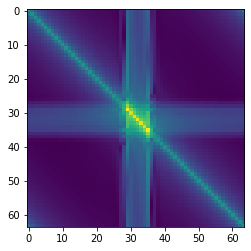

In [1410]:
plt.imshow(Mv_qe @ Hv_qe @ Mv_qe).real)

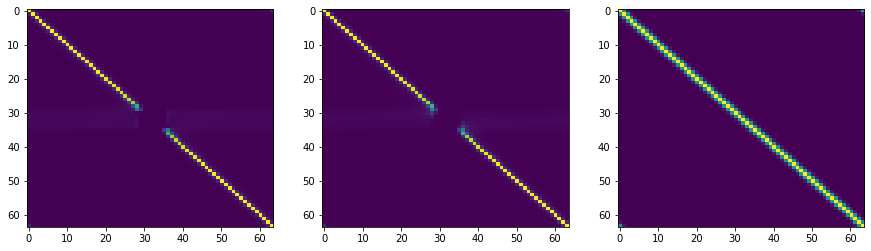

In [1416]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(Wv_gp.real, aspect='auto')
axes[1].imshow(Wv_qe.real, aspect='auto')
axes[2].imshow(Wv_id.real, aspect='auto')

(1e-06, 2.5286055868549604)

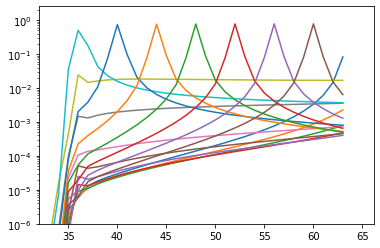

In [1417]:
plt.plot(Wv_gp[0::4].T)
plt.xlim(32, )
plt.yscale('log')
plt.ylim(1e-6, )

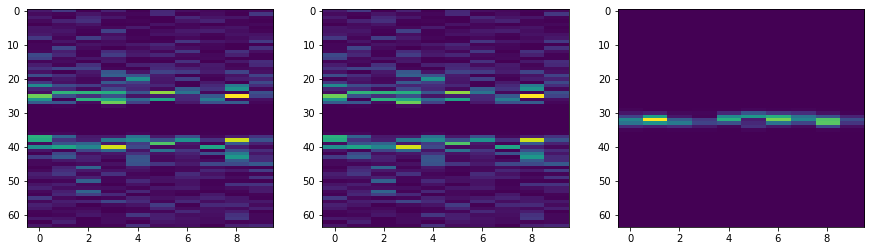

In [1361]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(qv_gp.real, aspect='auto')
axes[1].imshow(qv_qe.real, aspect='auto')
axes[2].imshow(qv_id.real, aspect='auto')

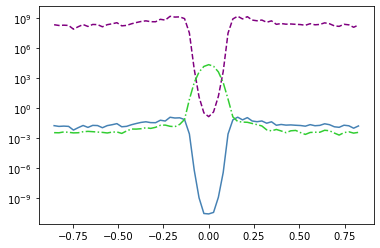

In [1362]:
plt.plot(kp, np.mean(qv_gp.real, axis=1), c='steelblue')
plt.plot(kp, np.mean(qv_qe.real, axis=1), ls='--', c='purple')
plt.plot(kp, np.mean(qv_id.real, axis=1), ls='-.', c='limegreen')

plt.yscale('log')

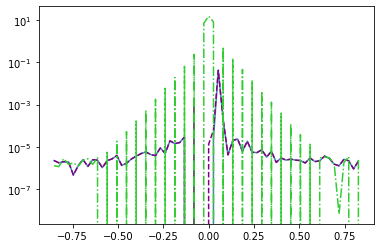

In [1363]:
plt.plot(kp, np.mean(pv_gp.real, axis=1), c='steelblue')
plt.plot(kp, np.mean(pv_qe.real, axis=1), ls='--', c='purple')
plt.plot(kp, np.mean(pv_id.real, axis=1), ls='-.', c='limegreen')

plt.yscale('log')

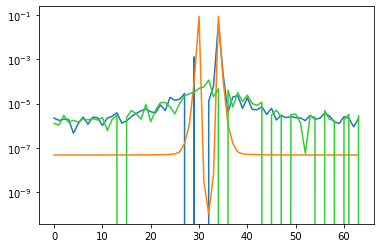

In [1364]:
plt.plot(np.mean(pv_qe, axis=1))
plt.plot(bv_qe)
plt.plot(np.mean(epv_id, axis=1), c='limegreen')
plt.yscale('log')

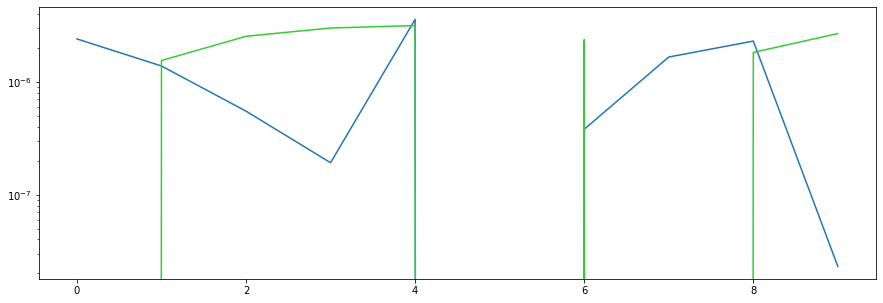

In [1365]:
plt.figure(figsize=(15, 5))
d = 5
plt.plot(pv_qe[d] - bv_qe[d])
plt.plot(epv_id[d], c='limegreen')
plt.yscale('log')

Text(0.05, 0.85, 'QE')

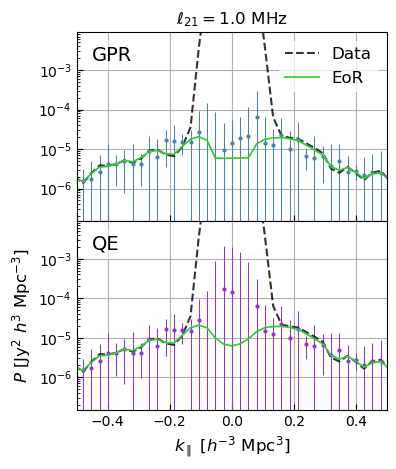

In [1477]:
fig, axes = plt.subplots(2, 1, figsize=(4, 5), dpi=100)
fig.subplots_adjust(hspace=0.0)
xlim = -.5, 0.5
ylim = 1.5e-7, 9e-3#8e1

ax = axes[0]
ax.tick_params(labelsize=10, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
p0 = ax.errorbar(kp, np.mean(pv_id, axis=1).real - bv_id, ls='--', c='k', lw=1.5, alpha=0.8)
ax.errorbar(kp, np.mean(pv_gp, axis=1).real - bv_gp, yerr=np.sqrt(np.diag(Cpv_gp)), fmt='o', c='steelblue',
            ms=2., elinewidth=0.75)
p1 = ax.errorbar(kp, np.mean(Wv_gp @ epv_id, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.text(0.05, 0.85, 'GPR', fontsize=14, transform=ax.transAxes, bbox=dict(ec='none', fc='w', alpha=0.5))
ax.legend([p0, p1], ['Data', 'EoR'], fontsize=12, edgecolor='none', framealpha=0.75)
ax.set_title(r'$\ell_{21} = 1.0\ {\rm MHz}$', fontsize=12)

ax = axes[1]
ax.tick_params(labelsize=10, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.errorbar(kp, np.mean(pv_id, axis=1).real - bv_id, ls='--', c='k', lw=1.5, alpha=0.8)
ax.errorbar(kp, np.mean(pv_qe, axis=1).real - bv_qe, yerr=np.sqrt(np.diag(Cpv_qe)), fmt='o', c='darkorchid',
            ms=2., elinewidth=0.75)
ax.errorbar(kp, np.mean(Wv_qe @ epv_id, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r'$k_\parallel$ [$h^{-3}$ Mpc$^3$]', fontsize=12)
ax.set_ylabel(r'$P\ [{\rm Jy}^2\ h^3\ {\rm Mpc}^{-3}]$', fontsize=12)
ax.text(0.05, 0.85, 'QE', fontsize=14, transform=ax.transAxes, bbox=dict(ec='none', fc='w', alpha=0.5))


Text(0.05, 0.85, 'QE')

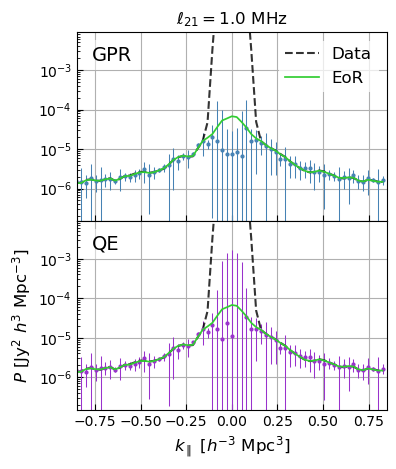

In [316]:
fig, axes = plt.subplots(2, 1, figsize=(4, 5), dpi=100)
fig.subplots_adjust(hspace=0.0)
xlim = -.85, 0.85
ylim = 1.5e-7, 9e-3#8e1

ax = axes[0]
ax.tick_params(labelsize=10, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
p0 = ax.errorbar(kp, np.mean(pv_id, axis=1).real - bv_id, ls='--', c='k', lw=1.5, alpha=0.8)
ax.errorbar(kp, np.mean(pv_gp, axis=1).real - bv_gp, yerr=np.sqrt(np.diag(Cpv_gp)), fmt='o', c='steelblue',
            ms=2., elinewidth=0.75)
p1 = ax.errorbar(kp, np.mean(epv_id, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.text(0.05, 0.85, 'GPR', fontsize=14, transform=ax.transAxes, bbox=dict(ec='none', fc='w', alpha=0.5))
ax.legend([p0, p1], ['Data', 'EoR'], fontsize=12, edgecolor='none', framealpha=0.75)
ax.set_title(r'$\ell_{21} = 1.0\ {\rm MHz}$', fontsize=12)

ax = axes[1]
ax.tick_params(labelsize=10, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.errorbar(kp, np.mean(pv_id, axis=1).real - bv_id, ls='--', c='k', lw=1.5, alpha=0.8)
ax.errorbar(kp, np.mean(pv_qe, axis=1).real - bv_qe, yerr=np.sqrt(np.diag(Cpv_qe)), fmt='o', c='darkorchid',
            ms=2., elinewidth=0.75)
ax.errorbar(kp, np.mean(epv_id, axis=1).real, c='limegreen', lw=1.25)
ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r'$k_\parallel$ [$h^{-3}$ Mpc$^3$]', fontsize=12)
ax.set_ylabel(r'$P\ [{\rm Jy}^2\ h^3\ {\rm Mpc}^{-3}]$', fontsize=12)
ax.text(0.05, 0.85, 'QE', fontsize=14, transform=ax.transAxes, bbox=dict(ec='none', fc='w', alpha=0.5))


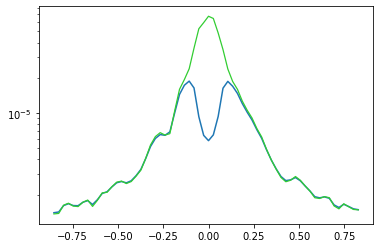

In [331]:
plt.plot(kp, np.mean(Wv_qe @ epv_id, axis=1).real)
plt.errorbar(kp, np.mean(epv_id, axis=1).real, c='limegreen', lw=1.25)
plt.yscale('log')

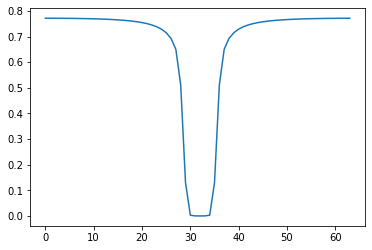

In [317]:
plt.plot(Wv_qe.diagonal().real)

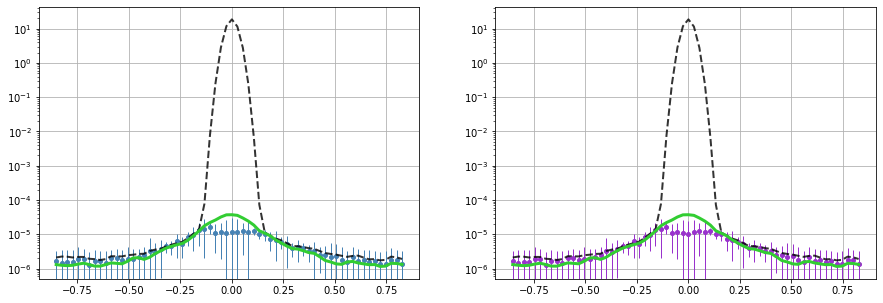

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.errorbar(kp, np.mean(pv_gp, axis=1).real - bv_gp, yerr=np.sqrt(np.diag(Cpv_gp)), fmt='o', c='steelblue',
            ms=4, elinewidth=1.)
ax.errorbar(kp, np.mean(pv_id, axis=1).real, ls='--', c='k', lw=2, alpha=0.8)
ax.errorbar(kp, np.mean(epv_id, axis=1).real, c='limegreen', lw=3)
ax.grid()
ax.set_yscale('log')

ax = axes[1]
ax.errorbar(kp, np.mean(pv_qe, axis=1).real - bv_qe, yerr=np.sqrt(np.diag(Cpv_qe)), fmt='o', c='darkorchid',
            ms=4, elinewidth=1.)
ax.errorbar(kp, np.mean(pv_id, axis=1).real, ls='--', c='k', lw=2, alpha=0.8)
ax.errorbar(kp, np.mean(epv_id, axis=1).real, c='limegreen', lw=3)
ax.grid()
ax.set_yscale('log')

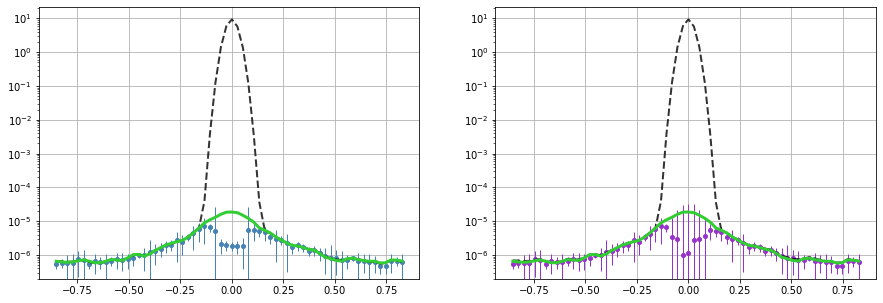

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.errorbar(kp, np.mean(pv_gp, axis=1).real - bv_gp, yerr=np.sqrt(np.diag(Cpv_gp)), fmt='o', c='steelblue',
            ms=4, elinewidth=1.)
ax.errorbar(kp, np.mean(pv_id, axis=1).real - bv_id, ls='--', c='k', lw=2, alpha=0.8)
ax.errorbar(kp, np.mean(epv_id, axis=1).real, c='limegreen', lw=3)
ax.grid()
ax.set_yscale('log')

ax = axes[1]
ax.errorbar(kp, np.mean(pv_qe, axis=1).real - bv_qe, yerr=np.sqrt(np.diag(Cpv_qe)), fmt='o', c='darkorchid',
            ms=4, elinewidth=1.)
ax.errorbar(kp, np.mean(pv_id, axis=1).real, ls='--', c='k', lw=2, alpha=0.8)
ax.errorbar(kp, np.mean(epv_id, axis=1).real, c='limegreen', lw=3)
ax.grid()
ax.set_yscale('log')

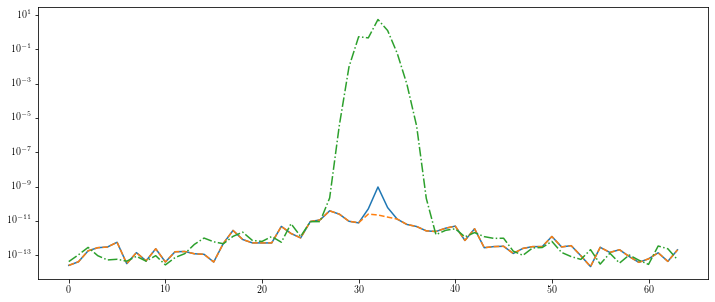

In [167]:
plt.figure(figsize=(12, 5))
plt.plot(np.diag(Cpv_gp))
plt.plot(np.diag(Cpv_qe), ls='--')
plt.plot(np.diag(Cpv_id), ls='-.')
plt.yscale('log')